In [1]:
## Loading functions
import os
os.chdir("/data/biocomp/bahin/qPCR/qPCRquantification/")
import HiFit_pd
from HiFit_pd import *
import qPCR_functions
from qPCR_functions import *

In [4]:
import importlib
importlib.reload(HiFit_pd)

NameError: name 'HiFit_pd' is not defined

In [2]:
## Creating HiFit colormap
import matplotlib
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

tab20 = matplotlib.cm.get_cmap("tab20")
HiFit_colormap = tab20.colors[::2] + tab20.colors[1::2]
random_colormap = LinearSegmentedColormap.from_list("HiFit_colormap", HiFit_colormap, N=20)
matplotlib.cm.register_cmap("HiFit_colormap", random_colormap)

In [3]:
cycles_col = ["F" + str(i).zfill(2) for i in range(40)]
cycles_col_norm = ["F" + str(i).zfill(2) + "_norm" for i in range(40)]
cycles_col_mod = ["F" + str(i).zfill(2) + "_mod" for i in range(40)]
cycles_col_mod_Gwb = ["F" + str(i).zfill(2) + "_mod_Gompertz_with_bump" for i in range(40)]
cycles_col_mod_GwbfE = ["F" + str(i).zfill(2) + "_mod_fixed_E_Gompertz_with_bump" for i in range(40)]

,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,F00,F01,F02,F03,...,F30_mod_Gompertz_with_bump,F31_mod_Gompertz_with_bump,F32_mod_Gompertz_with_bump,F33_mod_Gompertz_with_bump,F34_mod_Gompertz_with_bump,F35_mod_Gompertz_with_bump,F36_mod_Gompertz_with_bump,F37_mod_Gompertz_with_bump,F38_mod_Gompertz_with_bump,F39_mod_Gompertz_with_bump
0,S01-A01,PS1,RPL13a1,8.491106,1,1,0.370476,0.375293,0.379359,0.384355,...,0.970113,0.975771,0.980369,0.984102,0.987129,0.989583,0.991571,0.993181,0.994484,0.995539
1,S01-A02,PS1,RPL13a1,8.375671,1,2,0.351437,0.359487,0.363358,0.368100,...,0.970076,0.975709,0.980292,0.984017,0.987043,0.989499,0.991492,0.993107,0.994417,0.995479


,Median_Gompertz_E,Median_std_Gompertz_E
0,0.211595,0.004158
1,0.211595,0.004158
2,0.211595,0.004158
3,0.211595,0.004158
4,0.211595,0.004158


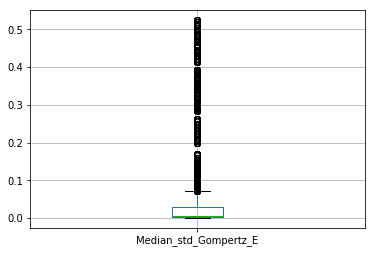

In [4]:
# Loading data
import pandas as pd

dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
#data = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t")
display(data.head(2))

data["Median_Gompertz_E"] = data.groupby(["Condition", "Gene"])["P_d_final_Gompertz_with_bump"].transform("median")
data["Median_std_Gompertz_E"] = data.groupby(["Condition", "Gene"])["P_d_final_Gompertz_with_bump"].transform("std")
display(data[["Median_Gompertz_E", "Median_std_Gompertz_E"]].head())
pd.DataFrame(data["Median_std_Gompertz_E"]).boxplot()

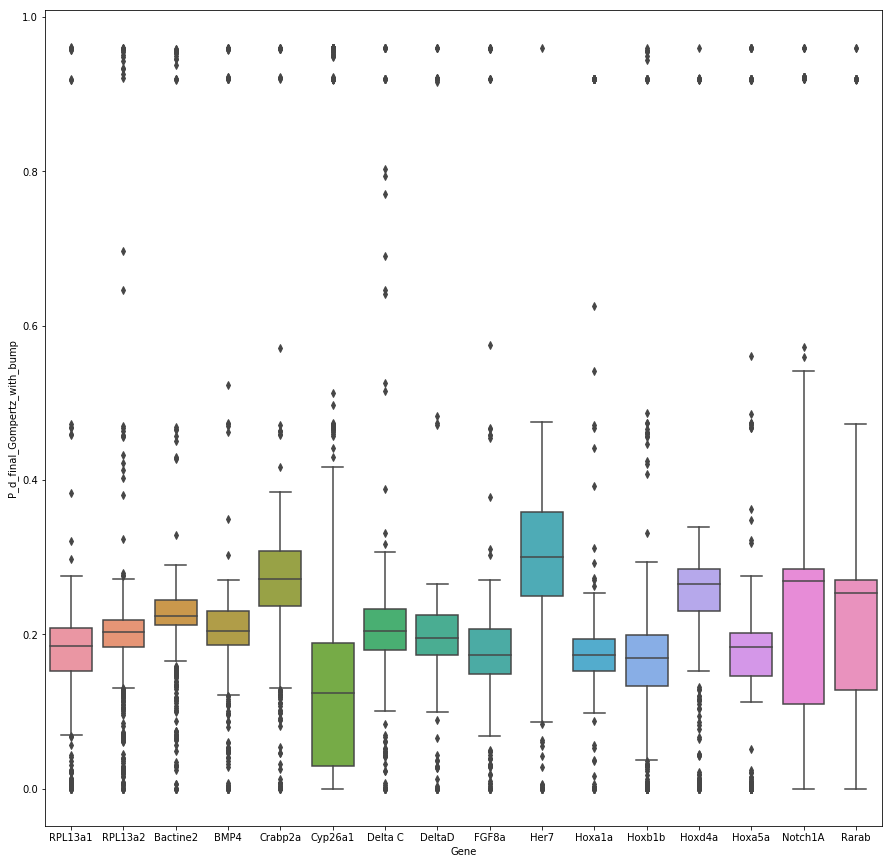

In [33]:
## Displaying the efficiency parameter distribution real one (and random in comments)
import matplotlib.pyplot as plt
import seaborn as sns

""" Randomizing the genes
s = data["Gene"].sample(frac=1)
s.index = data.index
df = s.to_frame().join(data["P_c_final_Gompertz_with_bump"])
"""

plt.figure(figsize=(15, 15))
sns.boxplot(x="Gene", y="P_d_final_Gompertz_with_bump", data=data)

In [6]:
## Display functions

def create_wellIDs(samples, assays):
    ''' Creates a list of well IDs according to the inputs. '''
    l = []
    for s in samples:
        for a in assays:
            l.append("S" + str(s).zfill(2) + "-A" + str(a).zfill(2))
    return l

def format_raw_fluo_data(data, cols, wellID, label):
    # Selecting the appropriate columns for the appropriate row
    df = data.loc[data.WellID.isin(wellID), ["WellID", "Condition"] + cols]
    # Melting the DataFrame (one row, several columns to several rows, several columns) 
    df = pd.melt(df, id_vars=["WellID"], value_vars=cols, var_name="Cycle", value_name="Value")
    # Transforming the cycles from "Fx" to "x"
    df["Cycle"] = df.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
    # Creating the column of the label
    df["Type"] = label
    return df

def format_equation_data(params, equation, wellID, label):
    # Generating the 40 values from the equation and parameters
    df = pd.DataFrame()
    for w, p in zip(wellID, params):
        df2 = pd.DataFrame(equation(np.array([range(40)]), *p))
        # Associating a well ID
        df2 = df2.assign(WellID=w)
        df = pd.concat([df, df2], sort=False, ignore_index=True)
    # Melting the DataFrame (one row, several columns to several rows, several columns)
    df = pd.melt(df, id_vars="WellID", value_vars=range(40), var_name="Cycle", value_name="Value")
    # Creating the column of the label
    df.loc[:, "Type"] = label
    return df

def plot_curves(data, style=None):
    sns.set()
    #plt.figure(figsize=(10, 10))
    if not style:
        #sns.lineplot(x="Cycle", y="Value", hue="Type", data=data)
        sns.relplot(x="Cycle", y="Value", hue="Type", units="WellID", estimator=None, kind="line", data=data)
    else:
        sns.lineplot(x="Cycle", y="Value", hue="Type", style=style, data=data)
    plt.title(data.iloc[0]["WellID"])
    #plt.ylim(-0.5, 1.5)

1 w1 RPL13a1 - PS1 df1
2 w2 RPL13a1 - PS2 df2
3 w3 RPL13a1 - PS3 df3
4 w4 RPL13a1 - PS4 df4
5 w5 RPL13a1 - PS5 df5
6 w6 RPL13a1 - PS6 df6


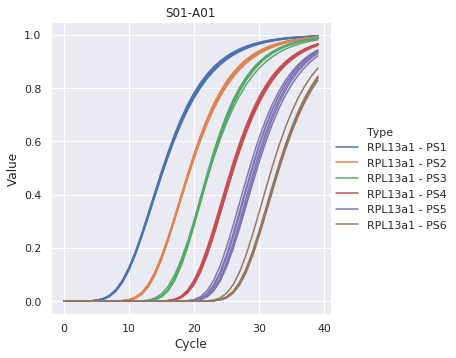

In [127]:
## Display curve(s) (modelled or raw)

cols = cycles_col
cols = cycles_col_mod_Gwb
#cols = cycles_col_mod_GwbfE
w = create_wellIDs([1], list(range(13, 19)))
w = create_wellIDs([1], [91])
w2 = create_wellIDs([], [76])
w2 = create_wellIDs([50], list(range(91, 97)))
#df = format_raw_fluo_data(data, ["S49-A13"], "Test_raw")
#df = format_raw_fluo_data(data, ["S49-A13", "S21-A87"], "Test_raw")
df = format_raw_fluo_data(data, cols, w, "S01-A91")
#df = format_raw_fluo_data(data, cols, w, "PS1_mod")
df2 = format_raw_fluo_data(data, cols, w2, "PC2")
#df2 = format_raw_fluo_data(data, cols, w2, "PC2_Fitted")
#df2 = format_raw_fluo_data(data, cols, w2, "PC2_mod")
#df2 = format_raw_fluo_data(data, w2, "PC1")
#df2 = format_raw_fluo_data(data, cycles_col, w2, "RPL13a2 - PS2")
#df2 = format_equation_data(np.array([[0.32, 1.04, 39.98, 0.26, -0.057, -0.11]]), Gompertz_with_bump, ["S07-A76"], "Fitted")

for i, j, k, l in zip(range(1, 7), ["w" + str(x) for x in range(1, 7)], ["RPL13a1 - PS" + str(x) for x in range(1, 7)],
                   ["df" + str(x) for x in range(1, 7)]):
    print(i, j, k, l)
    exec(j + " = create_wellIDs([" + str(i) + "], list(range(1, 7)))")
    exec(l + " = format_raw_fluo_data(data, cols, " + j + ", '" + k + "')")

"""
w1 = create_wellIDs([1], list(range(1, 7)))
df1 = format_raw_fluo_data(data, cols, w1, "RPL13a1 - PS1")
w2 = create_wellIDs([2], list(range(1, 7)))
df2 = format_raw_fluo_data(data, cols, w2, "RPL13a2 - PS2")
w3 = create_wellIDs([3], list(range(1, 7)))
df3 = format_raw_fluo_data(data, cols, w3, "RPL13a2 - PS3")
w4 = create_wellIDs([4], list(range(1, 7)))
df4 = format_raw_fluo_data(data, cols, w4, "RPL13a2 - PS4")
w5 = create_wellIDs([5], list(range(1, 7)))
df5 = format_raw_fluo_data(data, cols, w5, "RPL13a2 - PS5")
w6 = create_wellIDs([6], list(range(1, 7)))
df6 = format_raw_fluo_data(data, cols, w6, "RPL13a2 - PS6")
"""
df_list = [df1, df2, df3, df4, df5, df6]
df_total = pd.concat(df_list, sort=False, ignore_index=True)
#plot_curves(df3, "WellID")
plot_curves(df_total)

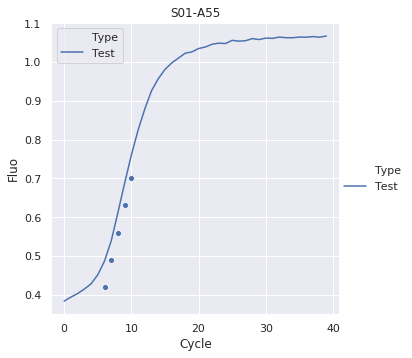

In [26]:
## Display raw curve(s)

# Setting the well(s)
#wellID = ["S01-A12", "S12-A58"]
wellID = ["S01-A55"]

df = format_raw_fluo_data(data, cycles_col, wellID, "Test")
plot_curves(df)

start_cycle = int(data.loc[data["WellID"] == wellID[0], "Rising_cycle"])
x = np.array(range(start_cycle + 1, start_cycle + 6)).reshape(-1, 1)
cycles = ["F" + str(c).zfill(2) for c in range(start_cycle + 1, start_cycle + 6)]
df2 = pd.DataFrame(x, columns=["Cycle"])
df2["Fluo"] = df2["Cycle"] * 0.07
sns.scatterplot(x="Cycle", y="Fluo", data=df2)

In [11]:
## File import to get the theoretical quantities
data_qty = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/well_comb_filtered.tsv", sep="\t")

,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,F00,F01,F02,F03,...,F32_mod_Gompertz_with_bump,F33_mod_Gompertz_with_bump,F34_mod_Gompertz_with_bump,F35_mod_Gompertz_with_bump,F36_mod_Gompertz_with_bump,F37_mod_Gompertz_with_bump,F38_mod_Gompertz_with_bump,F39_mod_Gompertz_with_bump,Median_Gompertz_E,Median_std_Gompertz_E
60,S01-A61,PS1,Hoxa1a,8.844158,1,61,0.287383,0.293551,0.299941,0.304981,...,0.977313,0.981408,0.984769,0.987526,0.989787,0.99164,0.993158,0.994401,0.203014,0.003383


,WellID,Cycle,Value,Type
0,S43-A01,0,0.338481,Raw
1,S43-A01,1,0.342768,Raw


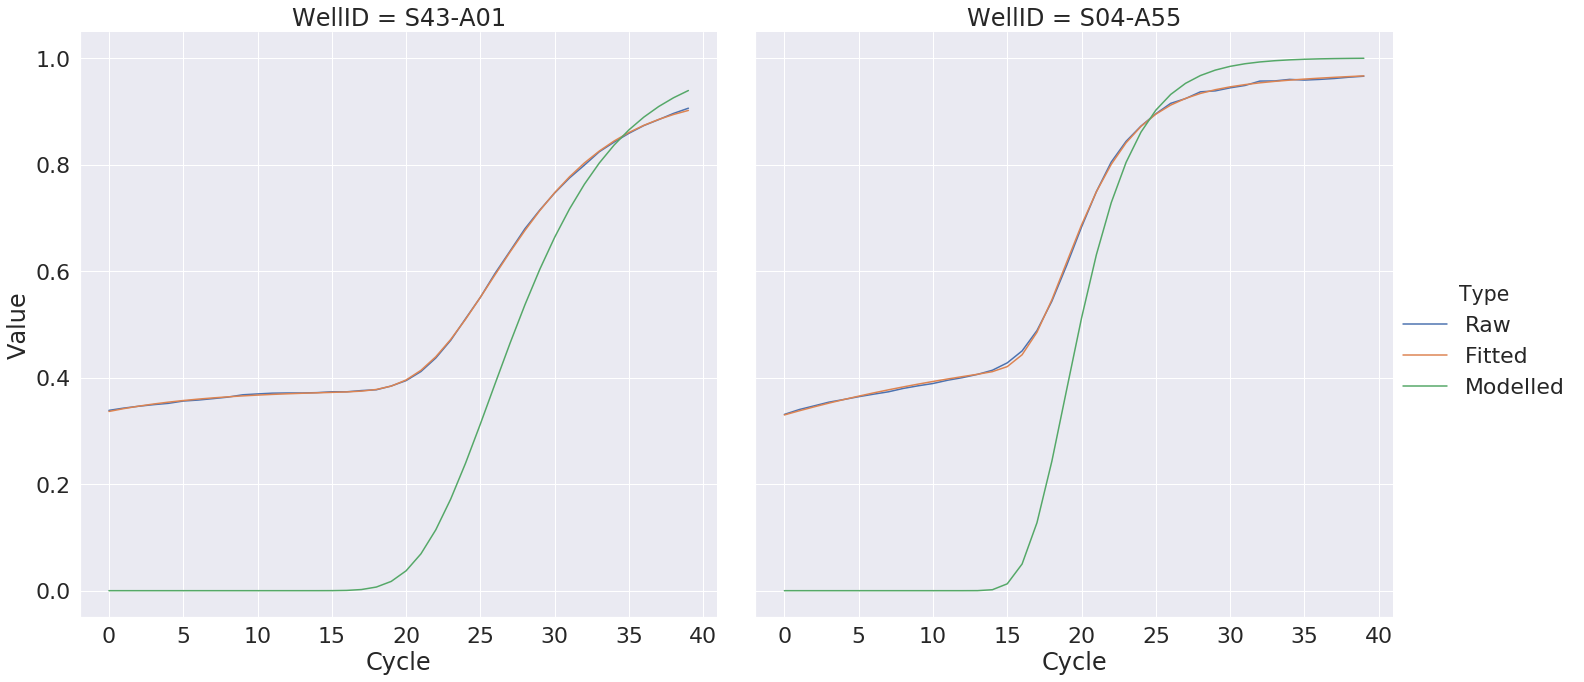

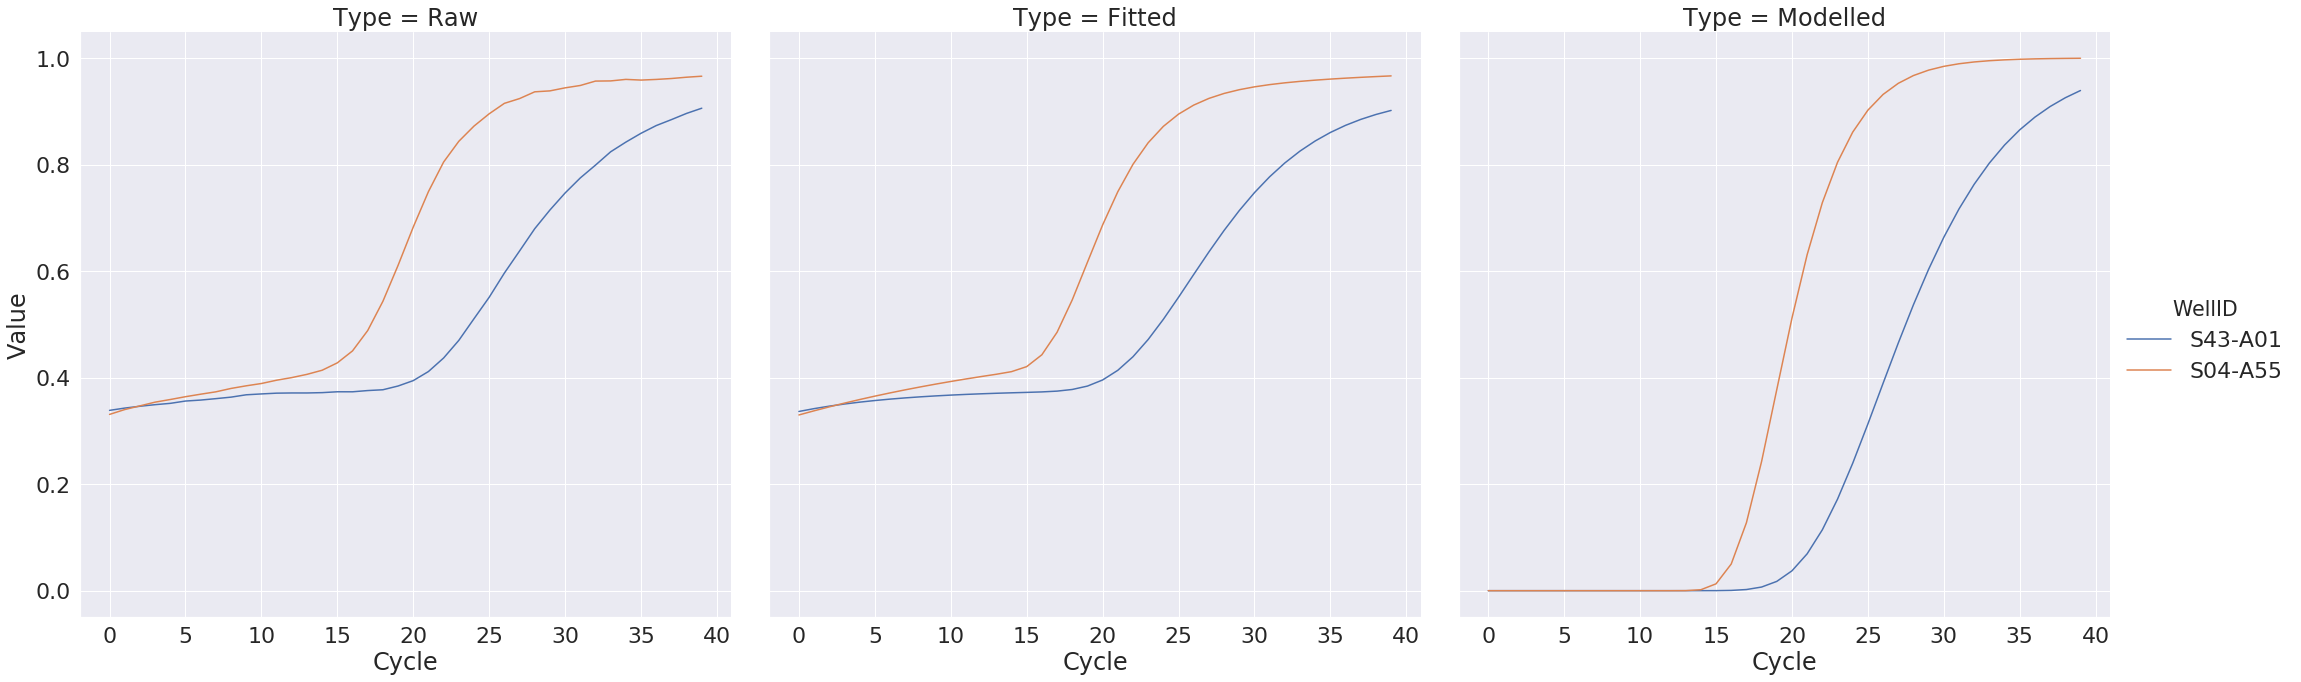

In [7]:
## Visualizing 2 curves (raw, fitted and modelled) to compare (and undertand why the E is bad)
import pandas as pd
import numpy as np
import seaborn as sns
import string

equation = Gompertz_with_bump
sample1 = 43
assay1 = 1
sample2 = 4
assay2 = 55
display(data.loc[data.WellID == "S01-A61", :])
wellID1 = "S" + str(sample1).zfill(2) + "-A" + str(assay1).zfill(2)
wellID2 = "S" + str(sample2).zfill(2) + "-A" + str(assay2).zfill(2)
w = create_wellIDs([sample1], [assay1])
w2 = create_wellIDs([sample2], [assay2])
#display(data.head(2))
df = format_raw_fluo_data(data, cycles_col, w, "Raw")
df2 = format_raw_fluo_data(data, cycles_col, w2, "Raw")
params = ["P_" + letter + "_final_" + equation.__name__ for letter in list(string.ascii_lowercase)[:equation.__code__.co_argcount - 1]]
df3 = format_equation_data(np.array(data.loc[data.WellID == wellID1, params]), equation, [wellID1], "Fitted")
df4 = format_equation_data(np.array(data.loc[data.WellID == wellID2, params]), equation, [wellID2], "Fitted")
df5 = format_raw_fluo_data(data, cycles_col_mod_Gwb, w, "Modelled")
df6 = format_raw_fluo_data(data, cycles_col_mod_Gwb, w2, "Modelled")
df = pd.concat([df, df2, df3, df4, df5, df6])
display(df.head(2))

sns.set(font_scale=2)
g = sns.FacetGrid(df, col="WellID", hue="Type", col_wrap=2, height=10)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Value", units="WellID", estimator=None).add_legend())

h = sns.FacetGrid(df, col="Type", hue="WellID", col_wrap=3, height=10)
h = (h.map_dataframe(sns.lineplot, "Cycle", "Value", units="Type", estimator=None).add_legend())

,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,F00,F01,F02,F03,...,F30_mod_Gompertz_with_bump,F31_mod_Gompertz_with_bump,F32_mod_Gompertz_with_bump,F33_mod_Gompertz_with_bump,F34_mod_Gompertz_with_bump,F35_mod_Gompertz_with_bump,F36_mod_Gompertz_with_bump,F37_mod_Gompertz_with_bump,F38_mod_Gompertz_with_bump,F39_mod_Gompertz_with_bump
0,S01-A01,PS1,RPL13a1,8.491106,1,1,0.370476,0.375293,0.379359,0.384355,...,0.970113,0.975771,0.980369,0.984102,0.987129,0.989583,0.991571,0.993181,0.994484,0.995539
1,S01-A02,PS1,RPL13a1,8.375671,1,2,0.351437,0.359487,0.363358,0.368100,...,0.970076,0.975709,0.980292,0.984017,0.987043,0.989499,0.991492,0.993107,0.994417,0.995479


/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


,WellID,Cycle,Value,Type,Eff
0,S55-A38,0,0.397271,Observed,NaN
1,S55-A38,1,0.406691,Observed,inf


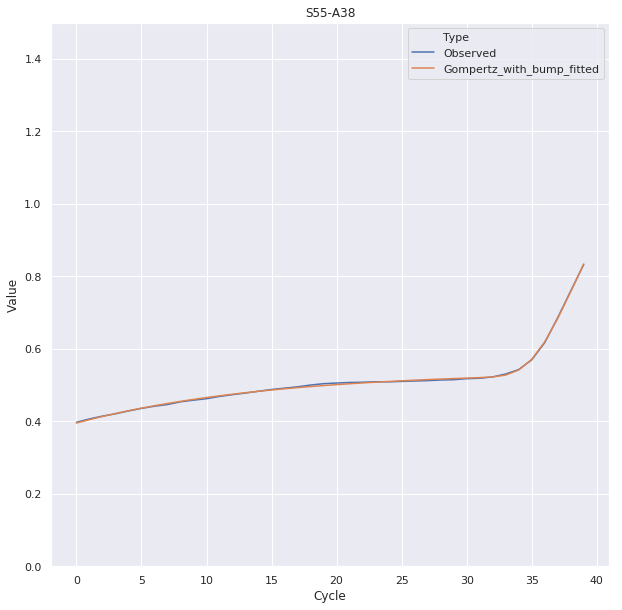

In [6]:
## Visualizing one curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
%matplotlib inline

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
#data = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t")
display(data.head(2))

# Setting the well
sample = "55"
assay = "38"
wellID = "S" + sample + "-A" + assay

# Formatting the observed fluo values
dataset = data.loc[data.WellID == wellID, ["WellID"] + cycles_col]
dataset = pd.melt(dataset, id_vars=["WellID"], value_vars=cycles_col, var_name="Cycle", value_name="Value")
dataset["Cycle"] = dataset.apply(lambda row: int(row["Cycle"][1:]), axis=1)
dataset["Type"] = "Observed"

# Building the fitted curves
#equations = [logistic4p_with_bump, logistic6p_with_bump, Gompertz_with_bump]
equations = [Gompertz_with_bump]
#equations = [logistic4p, logistic6p, Gompertz]
#equations = [logistic4p, logistic4p_with_bump, logistic6p, logistic6p_with_bump, Gompertz, Gompertz_with_bump]
df = dataset.copy()
for eq in equations:
    # Creating the fitted values
    params = ["P_" + letter + "_final_" + eq.__name__ for letter in list(string.ascii_lowercase)[0:eq.__code__.co_argcount - 1]]
    df_tmp = data.loc[data.WellID == wellID][params].astype(float).T.squeeze()
    fluo_fit = pd.DataFrame(eq(np.array([range(40)]), *df_tmp))
    fluo_fit = fluo_fit.assign(WellID=wellID)
    fluo_fit = pd.melt(fluo_fit, id_vars="WellID", value_vars=range(40), var_name="Cycle", value_name="Value")
    fluo_fit.loc[:, "Type"] = eq.__name__ + "_fitted"
    # Merging the 2 DataFrames
    df = pd.concat([df, fluo_fit], sort=False, ignore_index=True)
# Computing the cycle efficiency
for x in range(1, 39):
    #df.loc[df.Cycle == x, "Eff"] = df.loc[(df.Cycle == x) & (df.Type == "Observed"), "Value"] / df.loc[(df.Cycle == x - 1) & (df.Type == "Observed"), "Value"]
    y = x - 1
    #print(x, y)
    #print(df.loc[(df.Cycle == x) & (df.Type == "Observed"), "Value"])
    #print(df.loc[(df.Cycle == y) & (df.Type == "Observed"), "Value"])
    #sys.exit()
    df.loc[(df.Cycle == x) & (df.Type == "Observed"), "Eff"] = (df.loc[(df.Cycle == x) & (df.Type == "Observed"), "Value"].values - df.loc[(df.Cycle == 0) & (df.Type == "Observed"), "Value"].values) / (df.loc[(df.Cycle == y) & (df.Type == "Observed"), "Value"].values - df.loc[(df.Cycle == 0) & (df.Type == "Observed"), "Value"].values)
    #df.loc[:, "F" + str(x) + "_eff"] = df["F" + str(x - 1)] / df["F" + str(x)]
#display(fluo_fit.head())
display(df.head(2))
# Plotting the fluo curve
sns.set()
plt.figure(figsize=(10, 10))
plt.title(wellID)
plt.ylim(0, 1.5)
#plt.ylim(0.2, 0.4)
sns.lineplot(x="Cycle", y="Value", hue="Type", data=df)

In [53]:
## Fit one (even flat) curve and display raw and fitted ones
from scipy.optimize import minimize

water_samples = [12, 24, 36, 48, 60, 72, 84, 96]
data = qPCR_functions.gather_data("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/research_plate.tsv",
                                        9216, water_samples, "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/")

# Settings
sample = "02"
assay = "15"
wellID = "S" + sample + "-A" + assay
equation = Gompertz_with_bump

dataset = data.loc[data.WellID == wellID]
res = HiFitModel(dataset, 1000, equation, 5, False, 3, 70, "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/IPS.tsv",
                 "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/")
res = res[0]

# Formatting the observed fluo values
dataset = data.loc[data.WellID == wellID, ["WellID"] + cycles_col]
#dataset = data.loc[(data.WellID == wellID & data.Sigmoid_curve), ["WellID"] + cycles_col]
dataset = pd.melt(dataset, id_vars=["WellID"], value_vars=cycles_col, var_name="Cycle", value_name="Value")
dataset["Cycle"] = dataset.apply(lambda row: int(row["Cycle"][1:]), axis=1)
dataset["Type"] = "Observed"

# Building the fitted curves
df = dataset.copy()
# Creating the fitted values
params = ["P_" + letter + "_final_" + equation.__name__ for letter in list(string.ascii_lowercase)[0:equation.__code__.co_argcount - 1]]
df_tmp = np.array(res[params]).flatten()
fluo_fit = pd.DataFrame(equation(np.array([range(40)]), *df_tmp))
fluo_fit = fluo_fit.assign(WellID=wellID)
fluo_fit = pd.melt(fluo_fit, id_vars="WellID", value_vars=range(40), var_name="Cycle", value_name="Value")
fluo_fit.loc[:, "Type"] = equation.__name__ + "_fitted"
# Merging the 2 DataFrames
df = pd.concat([df, fluo_fit], sort=False, ignore_index=True)

# Plotting the fluo curve
sns.set()
plt.figure(figsize=(10, 10))
plt.ylim(0, 1.5)
plt.title(wellID)
sns.lineplot(x="Cycle", y="Value", hue="Type", data=df)

Loading qPCR data from file /data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/research_plate.tsv...
Out of the 9216 considered curves, 3155 are found to be flat (amplitude < 0.22474126712699116) or from water samples. They will be discarded for the further steps (6061 remaining curves).
Running HiFit model with Gompertz_with_bump equation...
Creating exhaustive initial parameter sets
Trying 5 random initial parameter sets (IPS) on a subset of 1000 curves...


NameError: name 'data' is not defined

NameError: name 'fluo' is not defined

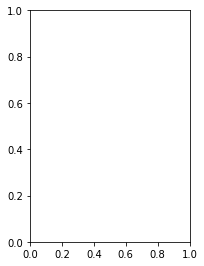

In [3]:
## Display the 96 curves for 1 sample
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def display_sample(sample, name, location):
    """ Function to display the 96 curves for 1 given sample. """
    ax = plt.subplot(nrows, n_plot_row, nb_sample)
    for assay in range(1,97):
        ax.plot(fluo.loc[sample + "-A{:02d}".format(assay)])
        axes = plt.gca()
        axes.set_ylim(0.1, 1.4)
    plt.title(name)

# Setting the range of curves to display (start and end)
start = 1
end = 49

# Setting the number of plot per row
n_plot_row = 6

# Displaying the curves
samples = range(start, end)  # Range of samples
nb_samples = range(1, end - start + 1)  # Range of samples starting at 1
nrows = int(math.ceil(float(len(samples)) / n_plot_row))  # Number of rows of n_plot_row plots
fig = plt.figure(figsize=(20, 5 * nrows))
for sample, nb_sample in zip(samples, nb_samples):
    display_sample("S" + "{:02d}".format(sample), "S" + "{:02d}".format(sample), nb_sample)

In [8]:
import natsort as ns

dataset = data.sort_values(by=["Gene", "Condition"])
dataset["Condition"] = pd.Categorical(dataset["Condition"], ordered=True, categories= ns.natsorted(dataset["Condition"].unique()))
dataset = dataset.sort_values("Condition")
print(dataset["Condition"].unique())

[10C_PC1, 10C_PC2, 10C_PC3, 10C_PC4, 10C_PC5, ..., PS8, PS9, PS10, PS11, PS12]
Length: 96
Categories (96, object): [10C_PC1 < 10C_PC2 < 10C_PC3 < 10C_PC4 ... PS9 < PS10 < PS11 < PS12]


,Gene,WellID,Condition,Pre_amplification,S_or_C,Dilution,Cycle,Fluo_value,Fluo_value_log
0,BMP4,S01-A19,PS1,0,PS,1,F00,0.222433,-1.503131
1,BMP4,S01-A20,PS1,0,PS,1,F00,0.217319,-1.526389


(-1.8, -0.8)

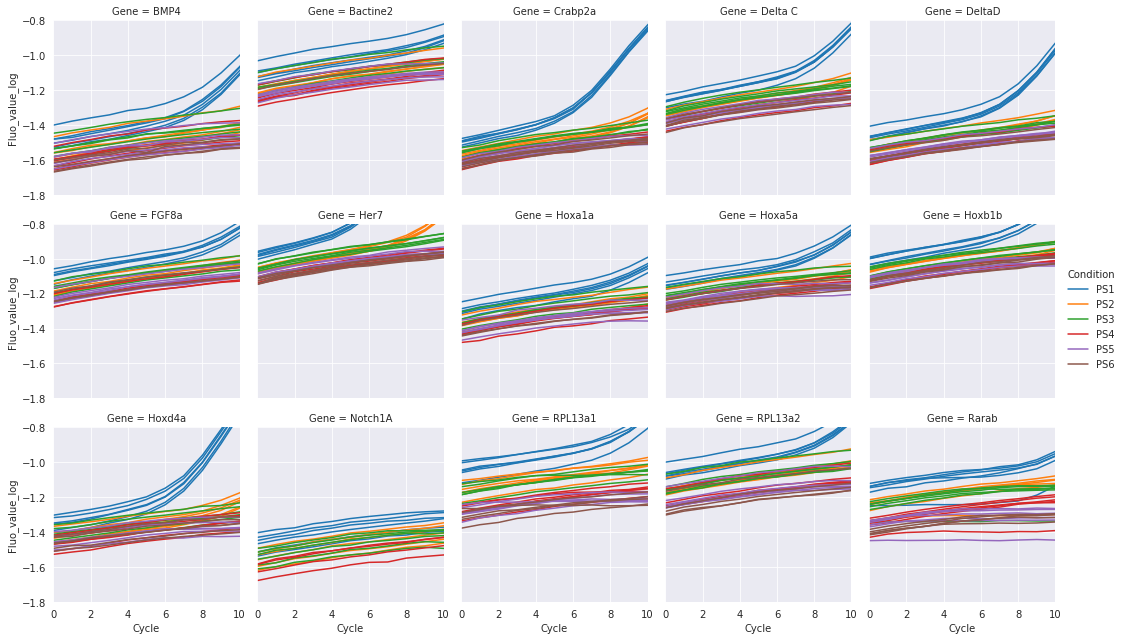

In [32]:
## Displaying raw curves
import seaborn as sns
import matplotlib.pyplot as plt

#condition_order = ["PC" + str(x) for x in range(1, 12)]
condition_order = ["PS" + str(x) for x in range(1, 7)]
dataset = data.loc[(data["Pre_amplification"] == 0) & (data["S_or_C"] == "PS") & (data["Sigmoid_curve"])]
dataset = dataset.sort_values(by=["Gene", "Condition"])
fluo = pd.melt(dataset, id_vars=["Gene", "WellID", "Condition", "Pre_amplification", "S_or_C", "Dilution"], var_name="Cycle", value_vars=cycles_col, value_name="Fluo_value")
fluo["Fluo_value_log"] = np.log(fluo["Fluo_value"])
display(fluo.head(2))
fluo.loc[:, "Cycle"] = fluo.apply(lambda row: int(row["Cycle"][1:]), axis=1)
sns.set_style("darkgrid")
g = sns.FacetGrid(fluo, col="Gene", hue="Condition", hue_order=condition_order, palette=HiFit_colormap, col_wrap=5)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Fluo_value_log", units="WellID", estimator=None).add_legend())
plt.xlim(0, 10)
plt.ylim(-1.8, -0.8)

(0, 1.6)

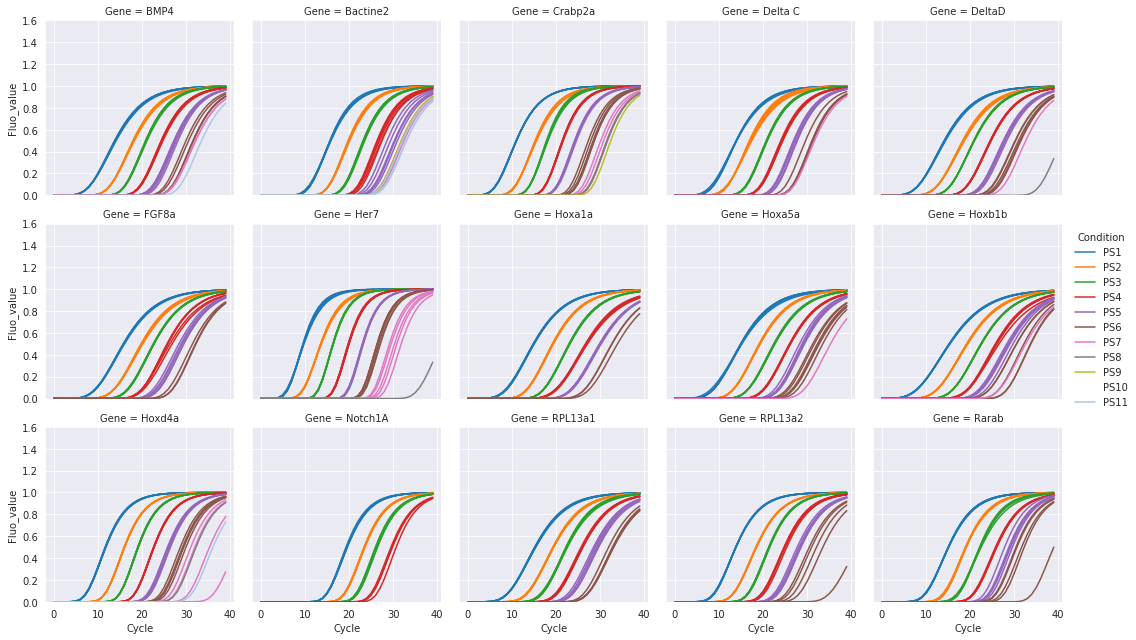

In [29]:
# Displaying modelled (Gompertz with bump fitting, from 0 to 1 without bump) curves
condition_order = ["PS" + str(x) for x in range(1, 12)]
dataset = data.loc[(data["Pre_amplification"] == 0) & (data["S_or_C"] == "PS") & (data["Sigmoid_curve"])]
dataset = dataset.sort_values(by=["Gene", "Condition"])
fluo = pd.melt(dataset, id_vars=["Gene", "WellID", "Condition", "Pre_amplification", "S_or_C", "Dilution"], var_name="Cycle", value_vars=cycles_col_mod_Gwb, value_name="Fluo_value")
fluo.loc[:, "Cycle"] = fluo.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
g = sns.FacetGrid(fluo, col="Gene", hue="Condition", hue_order=condition_order, palette=HiFit_colormap, col_wrap=5)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Fluo_value", units="WellID", estimator=None).add_legend())
plt.ylim(0, 1.6) 

(0, 1.6)

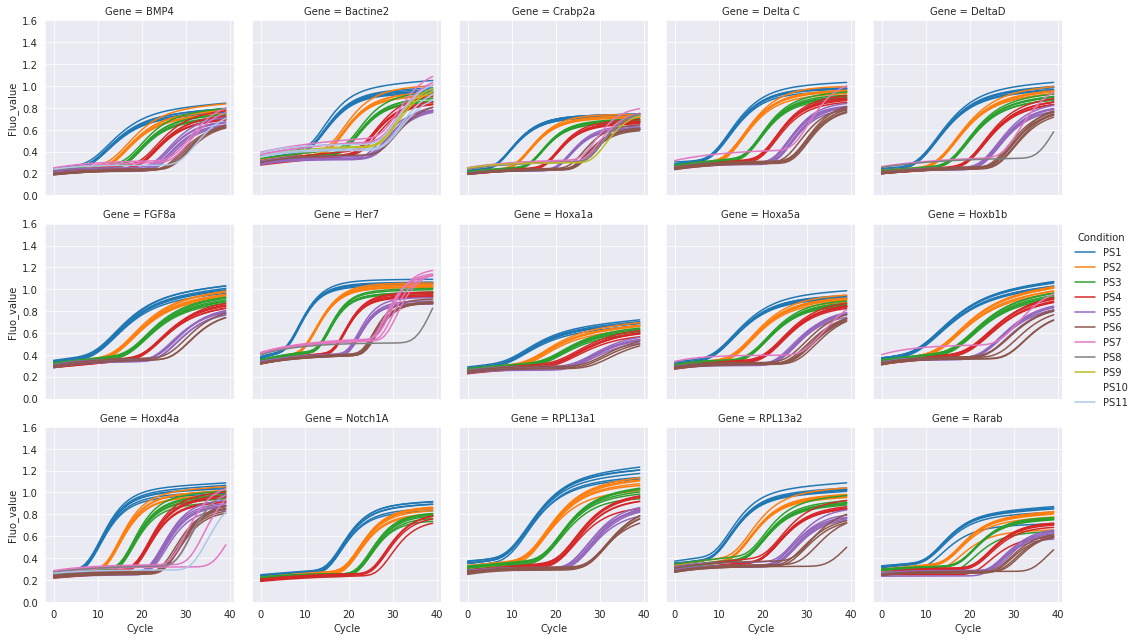

In [47]:
## Displaying the modelled curves tweaking the parameters

def modelled_fluo(row, equation):
    ''' Computing the 40 fluo values using chosen parameters for the equation. '''
    params = ["P_" + letter + "_final_" + equation.__name__ for letter in list(string.ascii_lowercase)[0:equation.__code__.co_argcount - 1]]
    args = row[params].values.tolist()
    #args[0:2] = [0, args[1] - args[0]]  # With min subtracted to min and max
    #args[4:6] = [0, 0]  # Without bump
    return equation(np.arange(40), *args)

# Setting parameters
equation = Gompertz_with_bump
cycles_name = ["F" + str(i).zfill(2) + "_mod_full_" + equation.__name__ for i in range(40)]

# Plotting the curves grid per gene and condition
condition_order = ["PS" + str(x) for x in range(1, 12)]
dataset = data.loc[(data["Pre_amplification"] == 0) & (data["S_or_C"] == "PS") & (data["Sigmoid_curve"])]
dataset[cycles_name] = dataset.apply(lambda row: modelled_fluo(row, equation), axis=1, result_type="expand")
dataset = dataset.sort_values(by=["Gene", "Condition"])
fluo = pd.melt(dataset, id_vars=["Gene", "WellID", "Condition", "Pre_amplification", "S_or_C", "Dilution"], var_name="Cycle", value_vars=cycles_name, value_name="Fluo_value")
fluo.loc[:, "Cycle"] = fluo.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
g = sns.FacetGrid(fluo, col="Gene", hue="Condition", hue_order=condition_order, palette=HiFit_colormap, col_wrap=5)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Fluo_value", units="WellID", estimator=None).add_legend())
plt.ylim(0, 1.6) 

(0, 1.6)

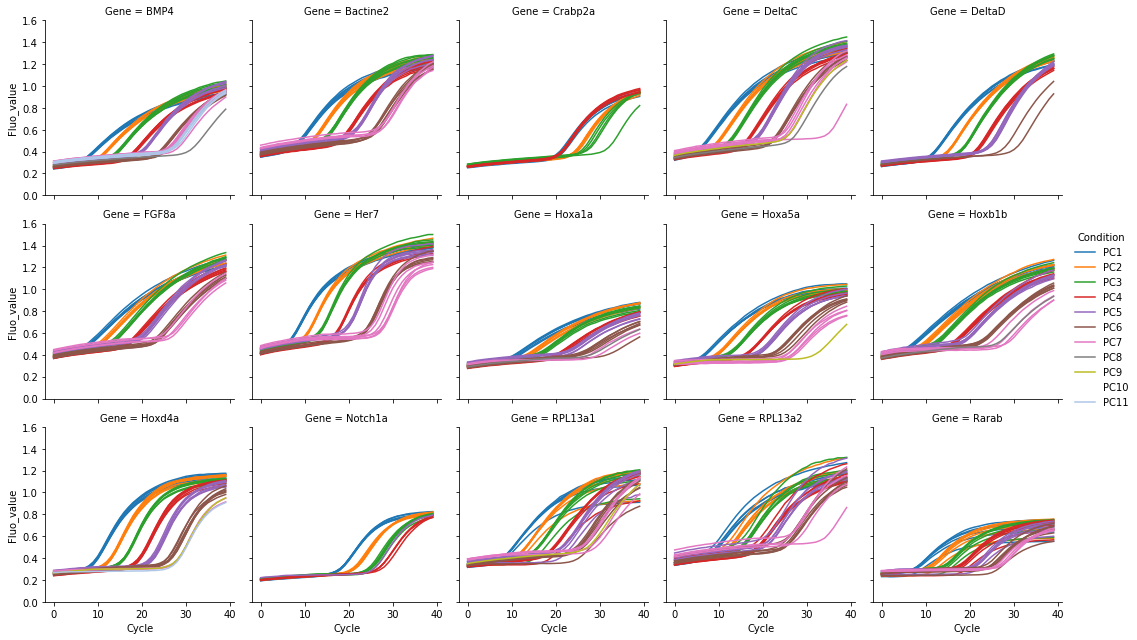

In [5]:
## Displaying the PC curves

# Plotting the curves grid per gene and condition
condition_order = ["PC" + str(x) for x in range(1, 12)]
dataset = data.loc[(data["Pre_amplification"] == 0) & (data["S_or_C"] == "PC") & (data["Sigmoid_curve"])]
dataset = dataset.sort_values(by=["Gene", "Condition"])
fluo = pd.melt(dataset, id_vars=["Gene", "WellID", "Condition", "S_or_C", "Dilution"], var_name="Cycle", value_vars=cycles_col, value_name="Fluo_value")
fluo.loc[:, "Cycle"] = fluo.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
g = sns.FacetGrid(fluo, col="Gene", hue="Condition", hue_order=condition_order, palette=HiFit_colormap, col_wrap=5)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Fluo_value", units="WellID", estimator=None).add_legend())
plt.ylim(0, 1.6) 

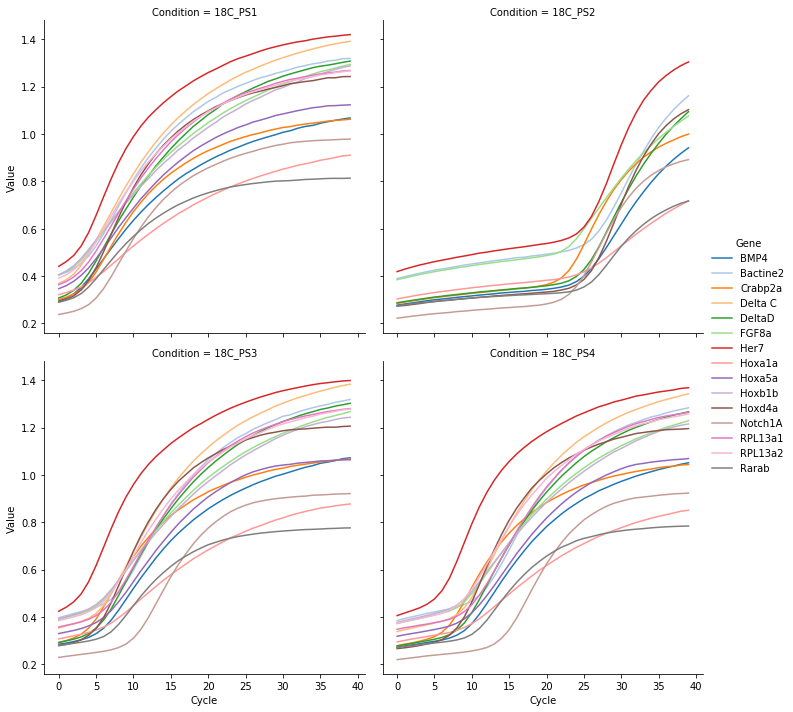

In [32]:
## Displaying genes PS1 mean curves
pa = ""
conditions = [pa + cond for cond in ["PS1", "PS2", "PS3", "PS4"]]
genes = ["Hoxa1a", "Hoxb1b", "Hoxd4a", "Hoxa5a"]
dataset = data.loc[(data.Condition.isin(conditions)) & (data.Sigmoid_curve)]
#dataset = data.loc[(data.Condition.isin(conditions)) & (data.Gene.isin(genes)) & (data.Sigmoid_curve)]
dataset_mean = dataset.groupby(["Gene", "Condition"]).mean().reset_index()
#print(dataset_mean.head(2))
#format_raw_fluo_data(dataset_mean, cycles_col, wellID, "Gene_median_PS1")
dataset_mean = pd.melt(dataset_mean, id_vars=["Gene", "Condition"], value_vars=cycles_col, var_name="Cycle", value_name="Value")
#print(dataset_mean.head())
# Transforming the cycles from "Fx" to "x"
dataset_mean["Cycle"] = dataset_mean.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
#print(dataset_mean.head())
g = sns.FacetGrid(dataset_mean, col="Condition", hue="Gene", palette="tab20", col_wrap=2, height=5)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Value", units="Gene", estimator=None).add_legend())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc84794bef0>]],
      dtype=object)

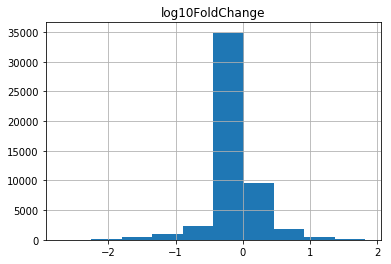

In [10]:
## EpenDiff FC distribution

import pandas as pd
import matplotlib
%matplotlib inline

df = pd.read_csv("/projects/biocompan/Finished/201708_IBENS_Spassky_EpendymaStages_A2017/Bioinformatics_platform/Ependiff_A2016/EpenDiff_A2016.PS_ready.reverse.tsv", sep="\t")

pd.DataFrame(df.log10FoldChange).hist()